# Graph Generation basato su attributi testuali
Obiettivo di questo notebook è quello di generare per ogni PA e Aggiudicatario una rappresentazione in uno spazio multidimensionale. Questa rappresentazione verrà usata per generare un grafo G(V,E) dove l'insieme dei nodi V rappresenta PA e Aggiudicatari, mentre l'insieme degli archi E definisce relazioni di similarità tra i nodi.

**Note**

Il dataset contiene 0 valori mancanti per il campo *cfStrutturaProponente* ed 8445 valori mancanti per il campo *cfPrimoaggiudicatario*. I valori mancanti verranno eliminati durante la fase di generazione dei documenti sintetici. Nonostante l'eliminazione di elementi con valori nulli, essendo il dataset molto sporco ci sono diversi  valori inconsistenti. Ad esempio ci sono stringhe formate da soli spazi o di sola punteggiatura speciale, stringhe non associate a reali p.iva o codici fiscali (e.g. "extra UE USA", "USA", "USA00004215"). Per fare ricerche basate su sottostringhe esegui il comando: 

``` python
example_df = df[pd.notnull(df['cfPrimoaggiudicatario'])]
example_df[example_df['cfPrimoaggiudicatario'].str.contains("USA|usa")==True]
```

Si definisce di seguito la soluzione proposta.


## Soluzione 1: creazione di vettori basati sul tf-idf

Ogni bando di gara è caratterizzato da un campo *oggetto*. Quindi per ogni elemento *i* ∈ { PA ⋃  Fornitori }, dove PA (Fornitori) è l’insieme delle Pubbliche amministrazioni (Fornitori) presenti nel dataset Anac,  è possibile creare un documento sintetico d<sub>i</sub> ottenuto concatenando il testo di tutti gli oggetti delle gare appartenenti ad *i*.

A partire da D = {d<sub>i</sub> | i ∈ { PA ⋃  Fornitori}} è possibile creare la matrice W ∈ R<sup>(n,m)</sup>, ottenuta calcolando il TF-IDF su D.

In questo modo è possibile creare un grafo G_text(V, E) dove V = { PA ⋃ Fornitori } ed esiste un arco pesato e = {(u, v) ∈ E | p(e) = cos(w<sub>u</sub>, w<sub>v</sub>)}  solo e soltanto se cos(w<sub>u</sub>, w<sub>v</sub>) >= *threshold*.

cos(w<sub>u</sub>, w<sub>v</sub>) ∈ [0,1], dove 0 implica che i documenti d<sub>u</sub>, d<sub>v</sub> sono completamente diversi, mentre 1 implica che i documenti hanno la stessa distribuzione di termini.


**Note**

- Dati i ∈ {PA} e j ∈ {Fornitori}, è possibile che se tutte le gare vinte da j riguardassero sempre i come struttura proponente (PA) e se tutte le gare di i siano vinte da j allora d<sub>i</sub> == d<sub>j</sub>, quindi cos(w<sub>i</sub>, w<sub>j</sub>) = 1.

- E’ possibile aggiungere al grafo G<sub>text</sub> nuovi nodi come l’insieme delle provincie e regioni. In questo caso è possibile associare ad ogni provincia (regione) i un documento sintentico d_i ottenuto concatenando tutti gli oggetti delle PA che insistono su i.  

- La matrice W non gestisce casi si sinonimia e polisemia (problema risolto con la soluziione successiva);

## Soluzione 2: creazione di vettori basati su word embedding dei top term pesati per il loro tf-idf

   Come nel precedente caso per ogni elemento i ∈ { PA ⋃  Fornitori }, dove PA (Fornitori) è l’insieme delle Pubbliche amministrazioni (Fornitori) presenti nel dataset Anac,  è possibile creare un documento sintetico d<sub>i</sub> ottenuto concatenando il testo di tutti gli oggetti delle gare appartenenti ad i. 

Sia *L* l’insieme delle top n ∈ N parole più frequenti (in termine di tf-idf)  e *D* = {d’<sub>i</sub> | i ∈ { PA ⋃  Fornitori } }, dove d’<sub>i</sub> = {(l, w) | l ∈ L e w = TF-IDF(l, d<sub>i</sub>)}. 

In questo modo per ogni i è possibile costruire un vettore v<sub>i</sub>  dato dalla somma pesata degli embedding dei termini l contenuti in d’<sub>i</sub>. 
Per esempio, sia  L = [“fattura”, “acquisto”, “fornitura”] l’insieme dei top 3 termini in D, e sia D ={d<sub>1</sub>, d<sub>2</sub>, d<sub>3</sub>}, dove:

- d<sub>1</sub> = [(“acquisto”: w(1,acquisto)), (“fattura”: w(1,fattura))]  
- d<sub>2</sub> = [(“fattura”: w(2,fattura)), (“fornitura”: w(2,fornitura))]  
- d<sub>3</sub> = [(“acquisto”: w(3,acquisto)), (“fattura”: w(3,fattura)), (“fornitura”: w(3,fornitura))]

Quindi è possibile per ogni d<sub>i</sub> calcolare una rappresentazione vettoriale cosi definita:

 
embedding(d<sub>i</sub>) = $ \frac{1}{\sum_{wj∈di} wj} * \sum_{(tj,wj)∈di}$ w<sub>j</sub> * embedding(t<sub>j</sub>)
    
    
 

dove embedding(t<sub>j</sub>) è l’embedding del termine t<sub>j</sub> appreso su Wikipedia (vedi [qui](https://fasttext.cc/docs/en/support.html) per maggiori dettagli).

In questo modo è possibile creare un grafo G<sub>text</sub>(V, E) dove V = { PA ⋃ Fornitori } ed esiste un arco pesato e = {(u, v) ∈ E | p(e) = cos(v<sub>du</sub>, v<sub>dv</sub>)}  solo e soltanto se cos(v<sub>du</sub>, v<sub>dv</sub>) >= threshold.



## Soluzione 3: creazione di vettori basati su word embedding dei top term 

   Questa soluzione è molto simile alla precedente. Tuttavia in questa soluzione tutti i termini contribuiscono in ugual misura all'embedding del documento. 
   
   In questo modo è possibile rappresentare d<sub>i</sub> come il centroide dei suoi termini:

 embedding(d<sub>i</sub>) = $ \frac{1}{\{tj | tj∈di\}} * \sum_{tj ∈ di}$ embedding(t<sub>j</sub>)
 
 
## Future Works

1. Al fine di discriminare maggiormente i documenti, si possono analizzare non sono parole di lunghezza 1, ma anche n-grammi (in questo modo documenti come {"fattura luce", "fattura telefono"} risultano meno simili )

In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')

from utils import textual_analysis

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import csv
import datetime
from time import time

from IPython.display import Image
from IPython.display import display

In [2]:
t = time()
#dir_ = "data/anac/"
dir_ = "data/final_data/row_data/"
file = dir_ + "anac_indicepa_2017.tsv" 
df = pd.read_csv(file, sep="\t")

total = time() - t
    
print("Loading dataframe done in %0.3f sec" %  total)
df.info(memory_usage='deep')

Loading dataframe done in 16.328 sec
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1774596 entries, 0 to 1774595
Data columns (total 26 columns):
Unnamed: 0                           int64
cig                                  object
cfStrutturaProponente                int64
denominazioneStrutturaProponente     object
oggetto                              object
sceltaContraente                     object
importoAggiudicazione                float64
importoSommeLiquidate                float64
dataInizio                           object
dataUltimazione                      object
jsonPartecipanti                     object
jsonAggiudicatari                    object
totalePartecipanti                   int64
totaleAggiudicatari                  int64
totaleRaggruppamentopartecipanti     int64
totaleRaggruppamentoAggiudicatari    int64
cfPrimoaggiudicatario                object
denominazionePrimoaggiudicatario     object
cod_amm                              object
regione           

## Creazione dei documenti sintetici d<sub>i</sub>

In questa sezione, per ogni attributo in *columns_to_aggregate*, è calcolato il suo documento sintetico 

In [3]:
columns_to_aggregate = {("cfStrutturaProponente","PA"), ("cfPrimoaggiudicatario","AGG")}

aggregate_df = textual_analysis.createSyntheticDF(df)

pd.options.display.max_colwidth = 500
aggregate_df.shape

Aggregation of attribute cfPrimoaggiudicatario done in 12.880 sec
Aggregation of attribute cfStrutturaProponente done in 1.421 sec


(317898, 3)

In [4]:
t = time()
file_name = "data/oggetti_aggregati.pickle"
aggregate_df.to_pickle(file_name)
total = time() - t

print("Dataset stored in %0.3f sec" % total)

Dataset stored in 0.593 sec


In [5]:
## libera memoria
#una volta lanciato questo comando verranno perse tutte le variabili inizializzate in precedenza
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.


## Creazione Matrice TF-IDF

La matrice dei tf-idf verrà utilizzata per entrambe le soluzioni. Prima di generare la matrice, sono eseguite le seguenti attività di preprocessing:
- Tokenization;
- Eliminazione di stopword (e.g. di, a, dell, quell, etc. );
- Selezione di parole composte solo da lettere e di cardinalità maggiore di 2 (e.g. eliminazione di codici di fattura)
- Eliminazione termini con frequenza nella collezione inferiore del 60% (i.e. max_df < 0.6) 

Alla matrice dei tf-idf generata è applicala la norma L2.


Inoltre si visualizzano di seguito le top 40 parole in termini di tf-idf.

In [6]:
#import warnings
#warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')

from utils import textual_analysis

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import csv
import datetime
from time import time

from IPython.display import Image
from IPython.display import display


In [7]:
def plotRankingAllTerms(sorted_frequents_words, title):
    """frequents_words: list of frequents words. Type: tuple(str, numpy.int64)
       title
    """
    #most_frequents_words = sorted(sorted_frequents_words, key = lambda x: x[1], reverse=True)
    x, y = zip(*sorted_frequents_words) # unpack a list of pairs into two tuples

    fig = plt.figure()
    ax1 = fig.add_subplot(111)  # Create matplotlib axes
    ax1.set_title(title)
    ax1.plot(x, y)
    ax1.axes.get_xaxis().set_ticks([])
    #ax1.set_yscale('log')
    #plt.ylabel('avg tf-idf score (log scale)')
    plt.ylabel('avg tf-idf score')
    
    fig.tight_layout()
    plt.savefig(file_name, pad = 0) #png
    plt.clf

In [8]:
#df_file_name = "data/oggetti_aggregati_.pickle"
dir_ = "data/enriched_data/n6/"
df_file_name = dir_ + "oggetti_aggregati_arricchiti.pickle"

t = time()
df = pd.read_pickle(df_file_name)
total = time() - t

print("Dataset loaded in %0.3f sec" % total)

df.info()

Dataset loaded in 0.283 sec
<class 'pandas.core.frame.DataFrame'>
Int64Index: 68642 entries, 0 to 244361
Data columns (total 13 columns):
cod_amm                   11141 non-null object
codiceFiscaleStruttura    68642 non-null object
comune                    68637 non-null object
forma_societaria          57492 non-null object
indirizzo                 68640 non-null object
nazione                   57501 non-null object
oggetto                   68642 non-null object
provincia                 68307 non-null object
ragione_sociale           57501 non-null object
regione                   68637 non-null object
tipoStruttura             68642 non-null object
tipologia_amm             11141 non-null object
tipologia_istat           11141 non-null object
dtypes: object(13)
memory usage: 7.3+ MB


In [9]:
t = time()

matrix, tf = textual_analysis.get_TFIDFmatrix_vect(df.oggetto, False)

total = time() - t

print("TFIDF matrix done in %0.3f sec" % total)
print("Shape TFIDF matrix", matrix.shape)

TFIDF matrix done in 12.406 sec
Shape TFIDF matrix (68642, 40024)


In [10]:
import pickle
pickle.dump(tf, open(dir_ + "tf.pickle", "wb"))
import scipy
scipy.sparse.save_npz(dir_ + 'sparse_matrix_tfidf.npz', matrix)

### Plot termini più discriminativi e distribuzione di termini per documento

Si può osservare come la frequenza dei termini segue la [legge di Zipf](https://it.wikipedia.org/wiki/Legge_di_Zipf). Infatti è possibile identificare un ristretto numero di termini caratterizzati da un alto tf-idf (i.e. fattura, fornitura, acquisto, pagamento, etc.), mentre la quasi totalità dei termini è caratterizzata da un tf-idf prossimo allo zero (vedi Fig.1 e Fig.2). 

Inoltre, si nota che i documenti sintetici generati hanno, nella maggioranza dei casi, un numero di parole distinte compreso tra 6 e 21. 

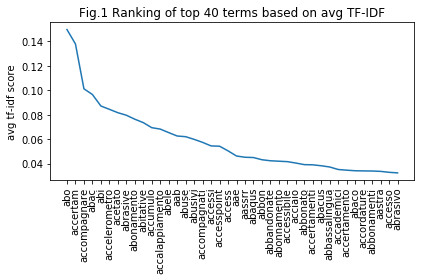

In [99]:
top_terms = 40

#Tf-Idf distribution
scores = zip(tf.get_feature_names(), np.asarray(matrix.mean(axis=0)).ravel())
sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
file_name = textual_analysis.plotTopNWords(sorted_scores, top_terms,  "Fig.1 Ranking of top "+ str(top_terms) + " terms based on avg TF-IDF")

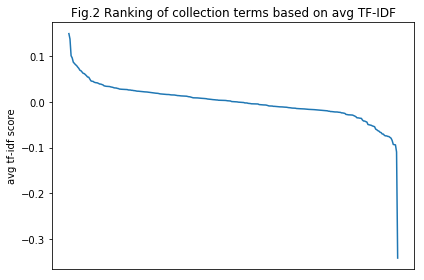

In [100]:
plotRankingAllTerms(sorted_scores,  "Fig.2 Ranking of collection terms based on avg TF-IDF")

In [13]:
rows = (matrix != 0).sum(1)
values = np.squeeze(np.asarray(rows))

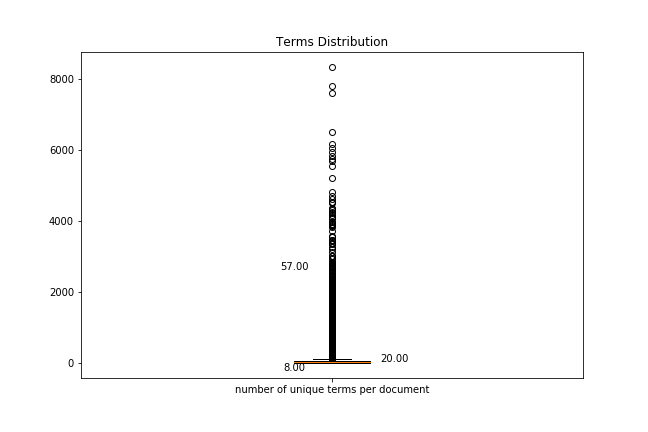

In [14]:
from pylab import text


# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(values)
plt.xticks([1], ["number of unique terms per document"])
plt.title("Terms Distribution")


for line in bp['medians']:
    # get position data for median line
    x, y = line.get_xydata()[1] # top of median line
    # overlay median value
    text(x + 0.05, y, '%.2f' % y, horizontalalignment='center') # draw above, centered

for line in bp['boxes']:
    x, y = line.get_xydata()[0] # bottom of left line
    text(x,y , '%.2f' % y, horizontalalignment='center', verticalalignment='top')      # below
    x, y = line.get_xydata()[3] # bottom of right line
    text(x, y*50, '%.2f' % y, horizontalalignment='center', verticalalignment='top')      # below

f_img = "imgs/n6/term_distribution.png"    
plt.savefig(f_img)
plt.clf()
plt.close()


i = Image(f_img)
display(i)

In [98]:
#seleziona tutti i documenti aventi una rappresentazione tfidf composta di soli zero
states = matrix.getnnz(1)== 0
row_indices = np.where(states)[0]
df.iloc[row_indices].head()

AttributeError: 'numpy.ndarray' object has no attribute 'getnnz'

## Implementazione Soluzione 1

Questa implementazione consiste nella sola creazione della matrice tf-idf (salvata in *data/n6/sparse_matrix_tfidf.npz*).

Alla matrice sono state applicate tecniche di dimensionality reduction (i.e. SVD). Tuttavia si è osservato che risultati migliori si sono ottenuti con la sola matrice sparsa. So lascia di seguito la generazione della matrice densa ottenuta applicando SVD e normalizzazione (L2).

In [ ]:
#from sklearn.decomposition import TruncatedSVD
#from sklearn.pipeline import make_pipeline
#from sklearn.preprocessing import Normalizer

#t0 = time()
#svd = TruncatedSVD(300)
#normalizer = Normalizer(copy=False)
#preprocessing = make_pipeline(svd, normalizer).fit_transform(matrix)
#total = time() - t0
#print("Preprocessing done in done in %0.3f sec" % total)

#np.save("data/n6/matrix_tfidf", preprocessing)

## Implementazione Soluzione 2

In questa sezione verranno caricati i documenti sintetici salvati in *data/oggetti_aggregati.pickle* e per ogni elemento verrà generata una rappresentazione vettoriale basata su *FastText*. Come per l'implementazione della soluzione 1 verranno analizzati solo i top k termini piu frequenti (i.e. tutti i termini con document frequency > 10).

Output di questa fase saranno la matrice degli embedding (i.e. ) e la matrice degli embedding normalizzata per L2(i.e.)

In [ ]:
#il modello appreso da FastText richiede 10 GB di Ram. 
#Quindi potrebbe essere utile rilasciare tutta la memoria allocata e ricaricare solo i dati necessari
%reset

In [16]:
#import warnings
#warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')

from utils import textual_analysis

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import csv
import datetime
from time import time

from IPython.display import Image
from IPython.display import display

In [18]:
import pickle
tf = pickle.load(open(dir_ + "tf.pickle", "rb"))

import scipy
matrix = scipy.sparse.load_npz(dir_ +  'sparse_matrix_tfidf.npz')

In [19]:
from gensim.models import KeyedVectors
t0 = time()
jp_model = KeyedVectors.load_word2vec_format('data/fasttext/cc.it.300.vec.gz')

total = time() - t0
print("Fastext model loaded in %0.3f sec" % total)

Fastext model loaded in 403.886 sec


Si analizzano di seguito i termini frequenti presenti nella matrice-tfidf ma non presenti in FastText

In [20]:
not_present = []

t0 = time()
for term in tf.vocabulary_:
    if term not in jp_model.vocab:
            not_present.append(term)
total = time() - t0
print("Intersection done in %0.3f sec" % total)        

len_not_present = len(not_present) 
percentage = len_not_present / len(tf.vocabulary_) 
print("Percentage of absent terms: %0.2f (i.e. %d terms)" % (percentage, len_not_present)) 
print("Printing some term not present in Fastext model: ",not_present[:10])

Intersection done in 0.020 sec
Percentage of absent terms: 0.16 (i.e. 6533 terms)
Printing some term not present in Fastext model:  ['memoweb', 'delleccidio', 'rcto', 'limbustamento', 'aagg', 'amnutenzione', 'sceltacontraente', 'ragionesociale', 'importoaggiudicazione', 'tempicompletamento']


In [28]:
t0 = time()
weighted = True
embedded_matrix = textual_analysis.calculate_embedding(tf, matrix, jp_model, matrix.shape[0], weighted)

total = time() - t0 
print("Embedding done in %0.3f sec" % total)

Embedding done in 170.953 sec


In [29]:
#check how many rows are all zero (it generates divisions by zero)
zero_rows = len(np.where(~embedded_matrix.any(axis=1))[0])
print("there are %d all zero rows" % zero_rows)

there are 760 all zero rows


In [30]:
t = len(tf.vocabulary_)
f = dir_ + "matrix_embedding_" + str(t) + "terms_weigthed" + str(weighted) 
np.save(f, embedded_matrix)

In [31]:
from sklearn.preprocessing import Normalizer
normalized_matrix = Normalizer(copy=False).fit_transform(embedded_matrix)
f = dir_ + "normalized_matrix_embedding_" + str(t) + "terms_weigthed" + str(weighted) 
np.save(f, normalized_matrix)

/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/sklearn/utils/extmath.py:71: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(norms, norms)


In [32]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.


## Generazione K nearest neighbors

Si generano di seguito i K nearest neighbors per ogni matrice generata (i.e. Soluzione 1,2 e 3).
In particolare per la matrice **sparsa** tf-idf si utilizzerà l'implementazione fornita da scikit-learn, mentre per le matrici **dense** degli embedding si utilizzerà la libreria *Faiss*.

### Generazione K nearest neighbors per la matrice tf-idf

In [33]:
k = 100

In [34]:
#import warnings
#warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')

from utils import textual_analysis

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import csv
import datetime
from time import time

from IPython.display import Image
from IPython.display import display

In [35]:
# matrice sparsa tfidf normalizzata con L2
import scipy.sparse
file_name = dir_ + "sparse_matrix_tfidf.npz"
matrix = scipy.sparse.load_npz(file_name)

In [36]:
t0 = time()
k = 100

I, D = textual_analysis.cosine_similarity_sparseMatrix(matrix, k, 1000)

total = time() - t0

print("K nearest neighbors done in %0.3f sec" % total)

Cosine similarity batch 0 done in 8.290 sec
Cosine similarity batch 1000 done in 8.285 sec
Cosine similarity batch 2000 done in 8.092 sec
Cosine similarity batch 3000 done in 7.314 sec
Cosine similarity batch 4000 done in 6.194 sec
Cosine similarity batch 5000 done in 6.037 sec
Cosine similarity batch 6000 done in 6.606 sec
Cosine similarity batch 7000 done in 6.405 sec
Cosine similarity batch 8000 done in 6.100 sec
Cosine similarity batch 9000 done in 6.167 sec
Cosine similarity batch 10000 done in 6.111 sec
Cosine similarity batch 11000 done in 3.981 sec
Cosine similarity batch 12000 done in 3.973 sec
Cosine similarity batch 13000 done in 3.892 sec
Cosine similarity batch 14000 done in 4.104 sec
Cosine similarity batch 15000 done in 3.981 sec
Cosine similarity batch 16000 done in 3.594 sec
Cosine similarity batch 17000 done in 3.474 sec
Cosine similarity batch 18000 done in 3.457 sec
Cosine similarity batch 19000 done in 3.514 sec
Cosine similarity batch 20000 done in 3.369 sec
Cosin

In [38]:
np.save(file_name + "similarity_D_" + str(k) + "_k", D)
np.save(file_name + "similarity_I_" + str(k) + "_k", I)

### Generazione K nearest neighbors per la matrice degli embedding

In [ ]:
k = 100

In [44]:
#matrice densa embedding non pesata 
#file_name = dir_ + "normalized_matrix_embedding_40024terms_weigthedFalse.npy"

#matrice densa embedding pesata con tfidf termini
file_name = dir_ + "normalized_matrix_embedding_40024terms_weigthedTrue.npy"

matrix = np.load(file_name).astype('float32')

In [45]:
##check how many rows are all zero (it generates divisions by zero)
#zero_rows = len(np.where(~matrix.any(axis=1))[0])
#print("there are %d all zero rows" % zero_rows)

In [46]:
t0 = time()

I, D = textual_analysis.inner_product_denseMatrix(matrix, k)

total = time() - t0
print("Inner Product done in %0.3f sec" % total)

Train index:  True
Total elements to analyze:  68642
Inner Product done in 14.545 sec


In [47]:
np.save(file_name + "similarity_D_" + str(k) + "_k", D)
np.save(file_name + "similarity_I_" + str(k) + "_k", I)

### Confronto K nearest neighbors
Di seguito si confrontano i K nearest neighbors estratti attraverso le matrici calcolate in precedenza.

La matrice generata dai tf-idf (i.e. Soluzione 1) sfrutta correlazioni dirette tra termini. Ossia due documenti sono simili se condividono gli stessi termini. Le matrici generate a partire dagli embedding dei termini (i.e. Soluzione 2, Soluzione 3) invece codificano correlazioni indirette tra termini. In quest'ultimo caso, due documenti sono simili se condividono termini semanticamente simili (e.g. raccolta, rifiuti, smaltimento).  

Per verificare se le rappresentazioni estratte per ogni documento codificano le stesse informazioni, si analizza l'intersezione dei k documenti più simili sfruttando le 3 matrici generate:
- Matrice tf-idf
- Matrice embedding
- Matrice embedding pesata con tf-idf

Per ogni coppia di matrici m1,m2, se queste codificano le stesse informazioni, allora per ogni documento d_i:

  
intersection(get_most_similar(m1, i, k), get_most_similar(m2, i, k))  ~= k,

dove *get_most_similar(mj, i, k)* restituisce i k documenti più simili al documento di indice i utilizzando la matrice mj. 


In [51]:
I_embeddings_weighted = np.load(dir_ + "normalized_matrix_embedding_40024terms_weigthedTrue.npysimilarity_I_100_k.npy")
D_embeddings_weighted = np.load(dir_ + "normalized_matrix_embedding_40024terms_weigthedTrue.npysimilarity_D_100_k.npy")

I_embeddings = np.load(dir_ + "normalized_matrix_embedding_40024terms_weigthedFalse.npysimilarity_I_100_k.npy")
D_embeddings = np.load(dir_ + "normalized_matrix_embedding_40024terms_weigthedFalse.npysimilarity_D_100_k.npy")

I_tfidf = np.load(dir_ + "sparse_matrix_tfidf.npzsimilarity_I_100_k.npy")
D_tfidf = np.load(dir_ + "sparse_matrix_tfidf.npzsimilarity_D_100_k.npy")

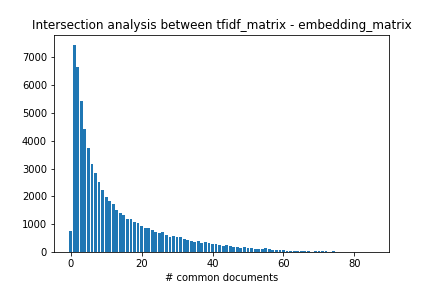

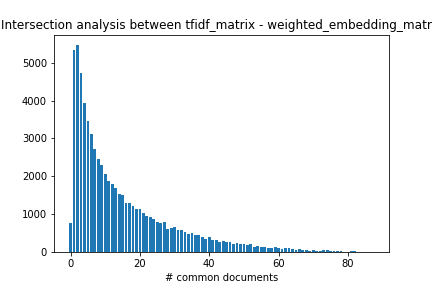

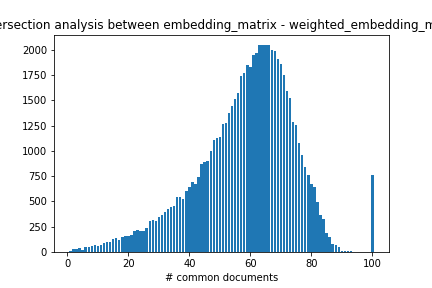

In [52]:
I_array = [I_tfidf, I_embeddings, I_embeddings_weighted]
k = len(I_embeddings[0])
labels = ["tfidf_matrix", "embedding_matrix", "weighted_embedding_matrix"]
intersection_array = []
str_labels = []

for i in range(len(I_array)):
    for j in range(i+1, len(I_array)):
    
        intersection = textual_analysis.get_intersection(I_array[i], I_array[j])
        intersection_array.append(intersection[:100000])
        title = "Intersection analysis between " + labels[i] + " - " + labels[j]
        f_img = "imgs/n6/intersection_"+ labels[i] + "." + labels[j] + "_k"+ str(k)+ ".png"
        str_labels.append(labels[i] + " vs " + labels[j])
        textual_analysis.bar_plot(pd.value_counts(intersection), title,f_img)

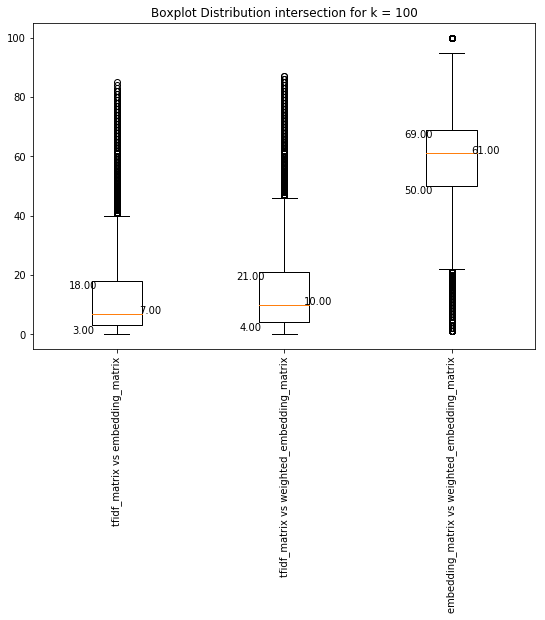

In [53]:
title = "Boxplot Distribution intersection for k = " + str(k)
filename = "imgs/n6/boxplot_comparisons_k"+ str(k)+ ".png"
       
textual_analysis.box_plot(intersection_array, str_labels, title, filename)

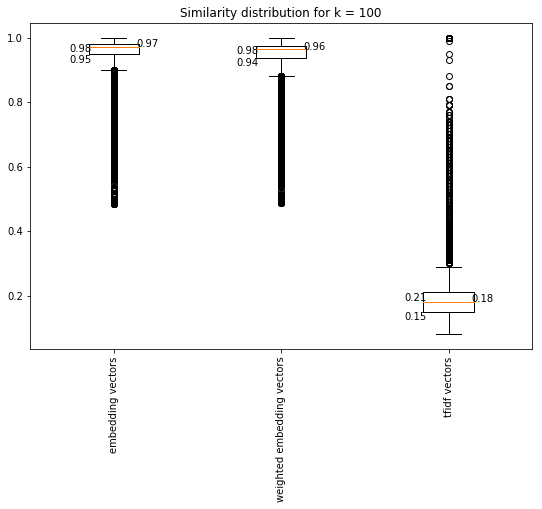

In [54]:
data_to_plot = [D_embeddings.ravel() [:100000], D_embeddings_weighted.ravel()[:100000],D_tfidf.ravel()[:100000]]
axis_labels = ['embedding vectors', 'weighted embedding vectors','tfidf vectors']
title = "Similarity distribution for k = "+ str(k)
filename = "imgs/n6/similarities_comparisons_k"+ str(k)+ ".png"
textual_analysis.box_plot(data_to_plot, axis_labels, title, filename)

### Visualizzazione dettaglio documenti strutture (i.e. Pa e Aggiudicatari) simili

Questa sezione permette di visualizzare in dettaglio i K nearest neighbors di un documento in input (utilizzando il suo indice di riga)
 

In [55]:
#import warnings
#warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')

from utils import textual_analysis

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import csv
import datetime
from time import time

from IPython.display import Image
from IPython.display import display

In [60]:
dir_ = "data/enriched_data/n6/"
I_embeddings_weighted = np.load(dir_ + "normalized_matrix_embedding_40024terms_weigthedTrue.npysimilarity_I_100_k.npy")
D_embeddings_weighted = np.load(dir_ + "normalized_matrix_embedding_40024terms_weigthedTrue.npysimilarity_D_100_k.npy")

I_embeddings = np.load(dir_ + "normalized_matrix_embedding_40024terms_weigthedFalse.npysimilarity_I_100_k.npy")
D_embeddings = np.load(dir_ + "normalized_matrix_embedding_40024terms_weigthedFalse.npysimilarity_D_100_k.npy")

I_tfidf = np.load(dir_ + "sparse_matrix_tfidf.npzsimilarity_I_100_k.npy")
D_tfidf = np.load(dir_ + "sparse_matrix_tfidf.npzsimilarity_D_100_k.npy")

In [61]:
#per individuare la riga in funzione del codice fiscale esegui il seguente comando
#df.reset_index(inplace = True)
#df_aggregati[df_aggregati["codiceFiscaleStruttura"] == "01934490762"]

In [87]:
#scegli struttura da analizzare (scelta basata su indice di riga della matrice)
#per individuare la riga in funzione del codice fiscale esegui il seguente comando

iloc_document_to_compare = 6705#34088 #i.e. si sta analizzando la struttura 2226

I_matrix1 = I_tfidf
D_matrix1 = D_tfidf

#scegli la matrici da confrontare
I_matrix2 = I_embeddings_weighted
D_matrix2 = D_embeddings_weighted

In [88]:
file_name = dir_ + "oggetti_aggregati_arricchiti.pickle"

t0 = time()
df_aggregati = pd.read_pickle(file_name)
total = time() - t0

print("Dataset loaded in %0.3f sec" % total)

df_aggregati.info()

Dataset loaded in 0.111 sec
<class 'pandas.core.frame.DataFrame'>
Int64Index: 68642 entries, 0 to 244361
Data columns (total 13 columns):
cod_amm                   11141 non-null object
codiceFiscaleStruttura    68642 non-null object
comune                    68637 non-null object
forma_societaria          57492 non-null object
indirizzo                 68640 non-null object
nazione                   57501 non-null object
oggetto                   68642 non-null object
provincia                 68307 non-null object
ragione_sociale           57501 non-null object
regione                   68637 non-null object
tipoStruttura             68642 non-null object
tipologia_amm             11141 non-null object
tipologia_istat           11141 non-null object
dtypes: object(13)
memory usage: 7.3+ MB


In [89]:
import pickle
tf = pickle.load(open(dir_ + "tf.pickle", "rb"))

import scipy
m = scipy.sparse.load_npz(dir_ + 'sparse_matrix_tfidf.npz')

In [90]:
pd.options.display.max_colwidth = 100
df_aggregati.iloc[[iloc_document_to_compare]]

,cod_amm,codiceFiscaleStruttura,comune,forma_societaria,indirizzo,nazione,oggetto,provincia,ragione_sociale,regione,tipoStruttura,tipologia_amm,tipologia_istat
index,,,,,,,,,,,,,
6705,istsc_apri03000a,82000470441,San Benedetto del Tronto,NaN,Viale dello Sport 60,NaN,formazione aggionamento sulla sicurezza di n 8 ore per docenti ed ata acquisto adattatori e hd p...,AP,NaN,Marche,PA,Pubbliche Amministrazioni,Istituti di Istruzione Statale di Ogni Ordine e Grado


In [91]:
commons_docs =  set(I_matrix1[iloc_document_to_compare]).intersection(set(I_matrix2[iloc_document_to_compare]))
df_most_similar = df_aggregati.iloc[list(commons_docs)]
df_most_similar["top_terms"] = textual_analysis.get_best_terms_frequencies(m, tf.get_feature_names(), commons_docs, 40)
df_most_similar.head()

/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,cod_amm,codiceFiscaleStruttura,comune,forma_societaria,indirizzo,nazione,oggetto,provincia,ragione_sociale,regione,tipoStruttura,tipologia_amm,tipologia_istat,top_terms
index,,,,,,,,,,,,,,
8768,istsc_pzis016001,91002170768,Maratea,NaN,Via San Francesco 16,NaN,spese telefonicheinternet 2017 kangourou della lingua inglese 2017 rimozione ghiaccio e sblocca...,PZ,NaN,Basilicata,PA,Pubbliche Amministrazioni,Istituti di Istruzione Statale di Ogni Ordine e Grado,minute:0.18 convitto:0.18 esercitazioni:0.13 salabar:0.13 pacco:0.12 ink:0.12 nautiche:0.12 fasc...
6337,istsc_anis01800e,81002070423,Fabriano,NaN,Largo Salvo D'Acquisto 2,NaN,materiale di ferramenta rifornimenti di carburante riparazione autobus cancelleria spese postali...,AN,NaN,Marche,PA,Pubbliche Amministrazioni,Istituti di Istruzione Statale di Ogni Ordine e Grado,rifornimenti:0.31 ipsia:0.20 ferramenta:0.16 moda:0.14 carburante:0.14 tessuti:0.14 igenici:0.14...
7457,istsc_chta02000x,83001610696,Scerni,NaN,"Via Colle Comune, 2",NaN,acquisto gruppi di continuita e licenza software fornitura giornali quotidiani acquisto sistema ...,CH,NaN,Abruzzo,PA,Pubbliche Amministrazioni,Istituti di Istruzione Statale di Ogni Ordine e Grado,agraria:0.18 azoto:0.15 vigneto:0.14 azienda:0.14 olive:0.13 reimpianto:0.12 cantina:0.12 bottig...
4808,istsc_nois006003,80011220037,Novara,NaN,"Via S.Bernardino Da Siena, 10",NaN,sofrtware archiviazione mail viaggio a londra viaggio di istruzione a roma pubblicita la stampa...,NO,NaN,Piemonte,PA,Pubbliche Amministrazioni,Istituti di Istruzione Statale di Ogni Ordine e Grado,nervi:0.26 lpm:0.25 bellini:0.22 itg:0.18 ipsia:0.15 atec:0.14 sfilata:0.13 viaggio:0.13 premia:...
8969,istsc_alis01300r,91021500060,Casale Monferrato,NaN,"Via Leardi, 1",NaN,noleggio pullman torino fornitura gasolio per mezzi convitto lampada videoproiettore aula multim...,AL,NaN,Piemonte,PA,Pubbliche Amministrazioni,Istituti di Istruzione Statale di Ogni Ordine e Grado,luparia:0.27 leardi:0.21 convitto:0.17 itas:0.16 agraria:0.15 iss:0.15 ita:0.14 iis:0.12 azienda...


In [97]:
pd.options.display.max_colwidth = 1000
df_aggregati.iloc[[iloc_document_to_compare]].oggetto

index
6705    formazione aggionamento sulla sicurezza di n 8 ore per docenti ed ata acquisto adattatori e hd per pc aula magna poste italiane conto contrattuale 2017 acquisto materiale per lab elettronica e manutenzione convitto disinfestazione e derattizzazione istituto assicurazione autoveicoli dellistituto ordine materiale stampante tridimensionale amici srl acquisto materiale per laboratorio acconciatori manutenzione lavatrice girbau alaggio a terra e sosta f palestini acquisto materiale per sostiruzione vetri rotti  acquisto materiale per laboratorio estetiste acquisto doghe in legno per il convitto polizze assicurative per istituto e convitto contratto di manutenzione e assistenza 2017 detersivi per lavatrici acquisto materiale elettrico per progetto ipsia plcarduinolab e allestimento  aula 23 acquisto detersivo e brillantante per lavastoviglie acquisto materiale per progetto ipsia plcarduinolab acquisto materiale per plotter roland sp540v acquisto prodotti pulizia per istituto e

### K nearest neighbors using tf-idf

In [93]:
pd.options.display.max_colwidth = 500
best_docs = I_matrix1[iloc_document_to_compare]
matrix_docs = df_aggregati.iloc[best_docs]
matrix_docs["top_terms"] = textual_analysis.get_best_terms_frequencies(m, tf.get_feature_names(), best_docs, 20)
matrix_docs["cosine_similarity"] = D_matrix1[iloc_document_to_compare]
matrix_docs[["ragione_sociale", "top_terms", "cosine_similarity"]]

/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,ragione_sociale,top_terms,cosine_similarity
index,,,
6705,NaN,convitto:0.22 sfilata:0.18 campetti:0.17 docenze:0.13 brillantante:0.13 frigorifere:0.12 frigorifera:0.11 aula:0.11 ostello:0.11 lavastoviglie:0.11 docenti:0.11 moda:0.10 detersivo:0.10 ipsia:0.10 detersivi:0.10 celle:0.10 materassi:0.09 esperti:0.09 haccp:0.09 cella:0.09,1.00
5976,NaN,sordi:0.25 convitto:0.23 detersivi:0.17 ipsia:0.16 isiss:0.16 protn:0.16 buono:0.15 stem:0.15 nomentana:0.15 bo:0.14 dordine:0.14 padova:0.13 itc:0.13 roma:0.12 antinfortunio:0.11 saldo:0.11 psicologo:0.11 frigorifera:0.11 scudo:0.10 torino:0.10,0.21
119526,ARIANNA PRINT S.R.L.S.,convitto:0.60 feste:0.60 tema:0.52,0.19
76807,COSE DI CASA SRL,brillantante:0.69 detersivo:0.56 lavastoviglie:0.46,0.19
110622,TECNOFRIGO GRANDI IMPIANTI SAS DI BOLLETTINI ALFREDO & C.,frigorifere:0.27 frigorifera:0.25 lido:0.22 convitto:0.22 celle:0.22 frigoriferi:0.21 detenuti:0.21 cella:0.21 cucina:0.19 lavastoviglie:0.19 frigo:0.19 selfservice:0.18 cordoni:0.18 delocalizzazione:0.17 sbt:0.17 tronto:0.15 congelatori:0.15 cc:0.15 fausto:0.15 bancone:0.14,0.19
117383,STAND UP,sfilata:1.00,0.18
66932,CASASICURA,convitto:0.81 allarme:0.59,0.18
8969,NaN,luparia:0.27 leardi:0.21 convitto:0.17 itas:0.16 agraria:0.15 iss:0.15 ita:0.14 iis:0.12 azienda:0.11 alessandria:0.11 vino:0.10 bus:0.10 serale:0.10 cantina:0.09 aula:0.09 mac:0.09 pullman:0.09 televisore:0.09 birra:0.08 istituto:0.08,0.18
6337,NaN,rifornimenti:0.31 ipsia:0.20 ferramenta:0.16 moda:0.14 carburante:0.14 tessuti:0.14 igenici:0.14 nashuatec:0.13 sfilata:0.12 semestrale:0.12 card:0.12 skill:0.11 personal:0.11 viaggio:0.11 bombola:0.11 fotocopie:0.10 informatico:0.10 istruzione:0.10 computer:0.10 dorsetti:0.10,0.17


### K nearest neighbors using embedding 

In [96]:
best_docs = I_matrix2[iloc_document_to_compare]
matrix_docs = df_aggregati.iloc[best_docs]
matrix_docs["top_terms"] = textual_analysis.get_best_terms_frequencies(m, tf.get_feature_names(), best_docs, 20)
matrix_docs["cosine_similarity"] = D_matrix2[iloc_document_to_compare]
matrix_docs[["ragione_sociale", "cod_amm", "top_terms", "cosine_similarity"]]

/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,ragione_sociale,cod_amm,top_terms,cosine_similarity
index,,,,
6705,NaN,istsc_apri03000a,convitto:0.22 sfilata:0.18 campetti:0.17 docenze:0.13 brillantante:0.13 frigorifere:0.12 frigorifera:0.11 aula:0.11 ostello:0.11 lavastoviglie:0.11 docenti:0.11 moda:0.10 detersivo:0.10 ipsia:0.10 detersivi:0.10 celle:0.10 materassi:0.09 esperti:0.09 haccp:0.09 cella:0.09,1.000000
7113,NaN,istsc_fiis01600e,odontotecnico:0.19 succursale:0.13 estetico:0.13 fabiani:0.12 dellindirizzo:0.11 nfp:0.11 rotoloni:0.11 nfattpa:0.10 linguistico:0.10 svuotatura:0.10 gita:0.10 alimentatori:0.09 imbiancatura:0.09 mobiletti:0.09 estetica:0.09 caricoscarico:0.09 indirizzo:0.09 laboratorio:0.09 webtrotter:0.09 computo:0.09,0.959704
10567,NaN,cc,coespu:0.17 egf:0.15 gpoi:0.13 frequentatori:0.12 cpm:0.12 poc:0.11 straniera:0.10 autorita:0.10 connesse:0.10 coffee:0.10 break:0.10 magistra:0.10 longare:0.09 castelfidardo:0.09 gp:0.09 docente:0.09 docenza:0.08 cena:0.08 addestrativo:0.08 poligono:0.08,0.959263
5944,NaN,gdf,castelporziano:0.18 gdf:0.13 accademia:0.12 laccademia:0.11 astc:0.11 allaccademia:0.10 vescovile:0.10 telerie:0.10 euroclass:0.09 poligono:0.09 vettovagliamento:0.09 dellaccademia:0.09 bergamo:0.09 running:0.09 scania:0.08 iniezione:0.08 forza:0.08 lavatura:0.08 skipass:0.08 ufficiali:0.08,0.959257
6425,NaN,istsc_bari05000g,corsisti:0.18 moda:0.17 lacquisto:0.16 andria:0.16 prot:0.15 barletta:0.15 linnovazione:0.14 modulo:0.14 cucire:0.13 team:0.12 autobus:0.12 pen:0.12 drive:0.12 tratta:0.12 docenti:0.12 assemblaggio:0.11 dellabbonamento:0.11 esercitazioni:0.11 tessuti:0.11 meccanico:0.11,0.958642
2098,NaN,fcaap,flaim:0.13 reparto:0.13 guardaroba:0.11 chiamata:0.10 degenti:0.09 stoviglie:0.09 cucina:0.08 divise:0.08 polverizzatore:0.08 counselling:0.08 aziendale:0.08 animazione:0.08 fisioterapia:0.08 reparti:0.08 counseling:0.08 letti:0.08 revisori:0.08 operatori:0.08 domicilio:0.08 accessi:0.08,0.958410
9264,NaN,istsc_BOIS02300G,lto:0.19 snodi:0.14 maker:0.12 occupabilita:0.12 ferroviari:0.12 formativi:0.11 pon:0.11 chimica:0.10 distruzione:0.10 chimici:0.10 texa:0.10 plugin:0.09 faire:0.09 biglietti:0.09 banconi:0.09 school:0.08 tornio:0.08 viaggio:0.08 laboratorio:0.08 pulmann:0.08,0.957921
9201,NaN,istsc_peis00600b,robotica:0.17 individuali:0.13 nao:0.10 challenge:0.10 bussi:0.10 faire:0.10 orienteering:0.10 liceo:0.10 viaggio:0.10 romania:0.09 pullman:0.09 individuale:0.09 docenti:0.09 innovazione:0.09 sulmona:0.09 monoposto:0.09 team:0.09 laboratori:0.09 bombola:0.09 inserzione:0.09,0.956703
4720,NaN,istsc_vais01700v,formatore:0.25 tutor:0.24 pon:0.21 agri:0.13 tagliata:0.13 utensilerie:0.12 mod:0.12 aa:0.11 cascina:0.11 dinamometro:0.10 fitness:0.09 mincio:0.09 compressore:0.09 elettrico:0.08 minolta:0.08 bombole:0.08 banchi:0.08 porte:0.08 palestra:0.08 ferramenta:0.08,0.956354
